<a href="https://colab.research.google.com/github/seenu-g/school_of_ai/blob/master/chap10/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "Albumentation library is successfully installed!"
!pip install -U git+https://github.com/NVIDIA/apex > /dev/null && echo "Apex library is successfully installed!"

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-bdqf7sdi
Albumentation library is successfully installed!
  Running command git clone -q https://github.com/NVIDIA/apex /tmp/pip-req-build-zu934lje
  Running command git submodule update --init --recursive -q
Apex library is successfully installed!


In [4]:
# mount gdrive and unzip data
from google.colab import drive
import sys
%load_ext autoreload
%autoreload 2
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
import sys
import os
folder = '/content/gdrive/My Drive/school_of_ai/chap10/'
os.chdir(folder)
print(os.getcwd()) 
for root, dirs, files in os.walk("."):
    for filename in files:
        print(filename)
sys.path.append(folder)

/content/gdrive/My Drive/school_of_ai/chap10
Trial.ipynb
gradcam.py
load_data.py
model.py
show_images.py
train_test.py
__init__.py
transforms.py
lr_finder.py
evaluate.py
plot.py
cifar-10-python.tar.gz
test_batch
data_batch_3
data_batch_2
data_batch_5
data_batch_1
data_batch_4
batches.meta
readme.html


In [0]:
%matplotlib inline
import torch
from template import load_data
from template import show_images
from template import model
from template import train_test
from template import evaluate
from template import transforms
from template import gradcam
from template import lr_finder
from template import plot

In [0]:
import albumentations as A
train_transform_list = [
                          A.Rotate((-30.0, 30.0)),
                          A.HorizontalFlip(),
                          A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                          A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                          A.Cutout(num_holes=1, max_h_size=16,max_w_size = 16,p=1) # fillvalue is 0 after normalizing as mean is 0
                       ]
test_transform_list = [A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))]
train_transform = transforms.AlbumentationTransforms(train_transform_list)
test_transform = transforms.AlbumentationTransforms(test_transform_list)

In [8]:
classes, trainloader, testloader = load_data.load(train_transform,test_transform)

Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


**Some Training Data**

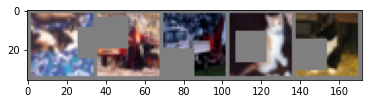

In [9]:
show_images.show_images(trainloader, classes)

**Print Model Summary**

In [10]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = model.ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

**LR Finder - Finds the best possible LR**


In [12]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR , MultiStepLR

criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(model.parameters(), lr=0.00001,momentum=0.9 ,weight_decay = 0.0001)
#scheduler = StepLR(optimizer, step_size=12, gamma=0.1)
lrfinder = lr_finder.LRFinder(model, optimiser, criterion, device="cuda")
lrfinder.range_test(trainloader, val_loader=testloader, end_lr=1, num_iter=600 ,step_mode="exp")


Learning rate search finished. See the graph with {finder_name}.plot()


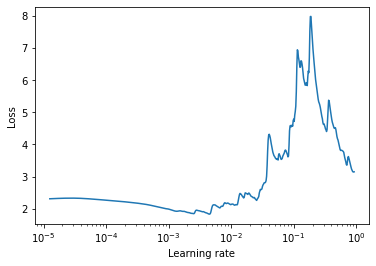

In [13]:
lrfinder.plot()

In [0]:
best_lr = lrfinder.history['lr'][lrfinder.history['loss'].index(lrfinder.best_loss)]

In [0]:
lrfinder.reset()

In [16]:
print(best_lr)

0.004466835921509632


In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR , MultiStepLR, ReduceLROnPlateau
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=best_lr,momentum=0.9 ,weight_decay = 0.0001)
scheduler = ReduceLROnPlateau(optimizer, patience = 3,min_lr=1e-4)

In [0]:
testLoss = []
testAcc = []
EPOCHS = 50
best_acc = 0
for epoch in range(EPOCHS):
     print("EPOCH:", epoch+1,'LR:',optimizer.param_groups[0]['lr'])
     train_loss, train_acc = train_test.train(model, device, trainloader, optimizer, criterion, epoch)
     test_loss , test_acc = train_test.test(model, device, criterion, testloader)
     scheduler.step(test_loss[-1])
     if(test_acc[-1]>best_acc):
       print("accuracy increased, Saving model....")
       best_acc = test_acc[-1]
       torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': test_loss[-1],
            }, "/content/gdrive/My Drive/school_of_ai/chap10/bestmodel.pt")

**Load the Best Accuracy Model**


In [30]:
optimizer = optim.SGD(model.parameters(), lr=best_lr,momentum=0.9 ,weight_decay = 0.0005)
checkpoint = torch.load("/content/gdrive/My Drive/school_of_ai/chap10/bestmodel.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
print("Loaded the best model")

Loaded the best model


In [31]:
evaluate.evaluate_accuracy(model, device, testloader)

Accuracy of the network on the 10000 test images: 91 %


In [32]:
evaluate.evaluate_classwise_accuracy(model, device, classes, testloader)

Accuracy of plane : 90 %
Accuracy of   car : 93 %
Accuracy of  bird : 83 %
Accuracy of   cat : 72 %
Accuracy of  deer : 94 %
Accuracy of   dog : 91 %
Accuracy of  frog : 100 %
Accuracy of horse : 89 %
Accuracy of  ship : 91 %
Accuracy of truck : 94 %


**Plot Loss Change in test**


Text(0.5, 1.0, 'Test Accuracy')

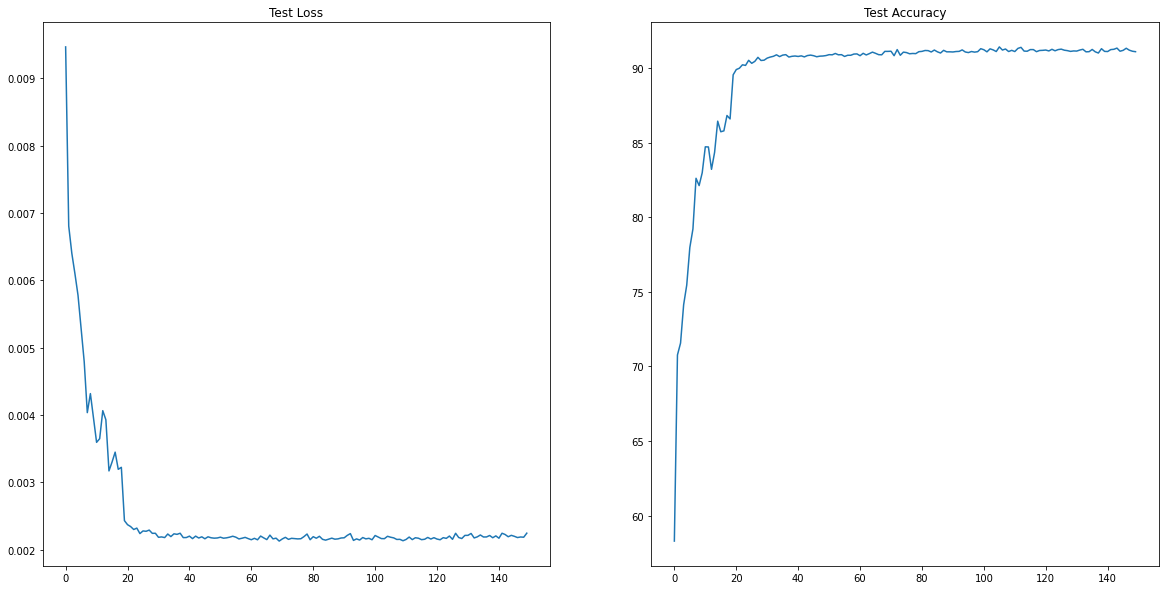

In [33]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(20,10))

axs[0].plot(test_loss)
axs[0].set_title("Test Loss")

axs[1].plot(test_acc)
axs[1].set_title("Test Accuracy")

**Plot Loss Change in train**


NameError: ignored

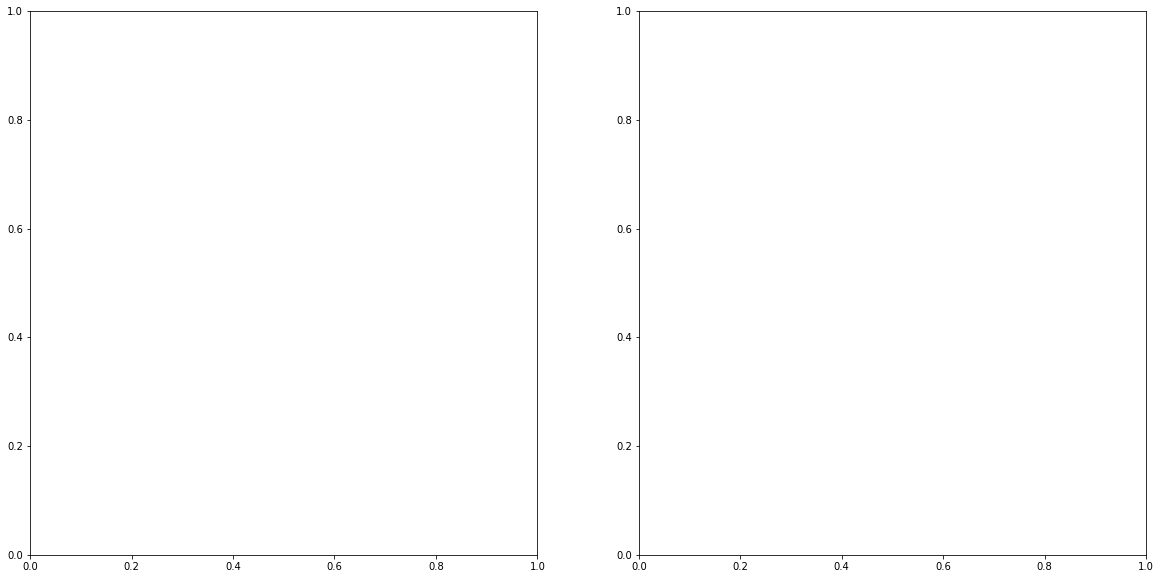

In [34]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(20,10))

axs[0].plot(train_loss)
axs[0].set_title("Train Loss")

axs[1].plot(train_acc)
axs[1].set_title("Train Accuracy")

In [0]:
import shutil
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

In [0]:
misclassified_images = evaluate.show_misclassified_images(model, device, testloader, classes)

**GradCam View of misclassified images(for all 4 layers)**


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from torchvision.utils import make_grid, save_image
fig = plt.figure(figsize=(23,30))
for i,k in enumerate(misclassified_images):
  images1 = [misclassified_images[i][0].cpu()/2+0.5]
  images2 =  [misclassified_images[i][0].cpu()/2+0.5]
  b = model.to(device)
  # output = model(misclassified_images[i][0])
  # _, predicted = torch.max(output.data, 1)
  #print(classes[int(predicted)])
  layers =  [model.layer1,model.layer2,model.layer3,model.layer4]
  for j in layers:
    g = gradcam.GradCAM(b,j)
    mask, _= g(misclassified_images[i][0].clone().unsqueeze_(0))
    heatmap, result = gradcam.visualize_cam(mask,misclassified_images[i][0].clone().unsqueeze_(0)/2+0.5 )
    images1.extend([heatmap])
    images2.extend([result])
  grid_image = make_grid(images1+images2,nrow=5,pad_value=1)
  npimg = grid_image.numpy()
  sub = fig.add_subplot(9, 3, i+1) 
 
  # fig.subplots_adjust(wspace=0)
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  sub.set_title('P = '+classes[int(misclassified_images[i][1])]+" A = "+classes[int(misclassified_images[i][2])],fontweight="bold",fontsize=18)
  sub.axis("off")
plt.tight_layout()
fig.subplots_adjust(wspace=0)